# osm_LoD1_3DCityModel Walkthrough

**The purpose of this notebook is to walk a user through [osm_LoD1_3DCityModel](https://github.com/AdrianKriger/osm_LoD1_3DCityModel/tree/main/village_campus).**


<div class="alert alert-block alert-warning"><b>This notebook will:</b>

> **1. allow the user to create a Level-of-Detail 1 (LoD1) [3D City Model](https://en.wikipedia.org/wiki/3D_city_model).**  
>
> **2. propose several [Geography and Sustainable Development Education *conversation starters*](#Section2) for Secondary and Tertiary level students**
</div>

<div class="alert alert-block alert-danger"><b></b>

***The [suburb](https://github.com/AdrianKriger/geo3D/tree/main/suburb)*** processing option is meant for areas with more than for **2 500 buildings**.</div>

In [1]:
import time
from datetime import timedelta
import tempfile

import os
from itertools import chain
import math

import requests
import overpass
import osm2geojson

import numpy as np
import pandas as pd
import geopandas as gpd
import topojson as tp

from shapely.geometry import polygon
from shapely.geometry import Point, Polygon #, LineString, , MultiPolygon, LinearRing, shape, mapping
from shapely.ops import snap
from shapely.ops import transform
from shapely.strtree import STRtree

import copy
import json

import pyproj

import city3D

from osgeo import gdal, ogr, osr

import triangle as tr

from openlocationcode import openlocationcode as olc

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

**A `parameter.json` defines the path and files**.

In [3]:
jparams = json.load(open('osm3DwStock_param.json'))       
#jparams = json.load(open('osm3DsRiver_param.json'))    
#jparams = json.load(open('osm3DuEstate_param.json'))   
#jparams = json.load(open('osm3DwEstate_param.json'))      
#jparams = json.load(open('osm3Dobs_param.json')) 
#jparams = json.load(open('osm3Dcput_param.json'))       

**Harvest [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap)** - interogate an osm.pbf (["Protocolbuffer Binary Format"](https://wiki.openstreetmap.org/wiki/PBF_Format)) from within Jupyter and convert to .geojson.

<div class="alert alert-block alert-info"><b></b> 
    
**PLEASE SUPPLY YOUR OWN [osm.pbf](https://wiki.openstreetmap.org/wiki/PBF_Format).**  

**Either crop an area directly from [OpenStreetMap]() with the ***[official tool](https://www.openstreetmap.org/export#map=3/0.70/22.15)***, select a predefined area [from any number of providers](https://wiki.openstreetmap.org/wiki/Planet.osm), such as ***[Geofabrik](https://download.geofabrik.de)***, or...**
</div>

<div class="alert alert-block alert-success"><b></b>
    
**... download your own. Provincial extracts for South Africa are available here:** *http://download.openstreetmap.fr/extracts/africa/south_africa/*</div>

In [4]:
# Input OSM PBF file
input_pbf = "./data/CapeTown.osm.pbf"

# GeoPackage file [will be created]
#output_gpkg = "./data/output_polygons.gpkg"

**Lets first harvest the boundary of the area; we want to interogate**

In [5]:
#- get the area [suburb]
query = """[out:json][timeout:30];
        area[boundary=administrative][name='{0}'] -> .a;
        (
        way[amenity='university'][name='{1}'](area.a);
        relation[place][place~"sub|town|city|count|state|village|borough|quarter|neighbourhood"][name='{1}'](area.a);
        );
        out geom;
        """.format(jparams['LargeArea'], jparams['FocusArea'])

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
#rr = r.read()
area = osm2geojson.json2geojson(r.json())
#read into .gpd
aoi = gpd.GeoDataFrame.from_features(area['features'])
#aoi = aoi.set_crs(4326, allow_override=True)
if jparams['osm_type'] == 'relation' and len(aoi) > 1:
    for i, row in aoi.iterrows():
        if row.tags != None and 'place' in row.tags:
            focus = row
            
    trim = pd.DataFrame(focus)
    trim = trim.T
    aoi = gpd.GeoDataFrame(trim, geometry = trim['geometry'])
    #aoi = aoi.set_crs(4326)

# Drop rows where geometry is None or NaN
aoi = aoi.dropna(subset=['geometry'])
aoi = aoi.set_crs(4326, allow_override=True)

# gt the bounding box (BBOX) of the GeoJSON boundary
minx, miny, maxx, maxy = aoi.total_bounds
bbox_filter = "-spat", str(minx), str(miny), str(maxx), str(maxy)
aoi.head(2)

,geometry,type,id,tags
0,"MULTIPOLYGON (((18.43942 -33.93323, 18.43952 -...",relation,2034285,"{'boundary': 'place', 'name': 'Woodstock', 'pl..."


**Only harvest what we need from the osm.pbf.**

In [6]:
start = time.time()

gdal.UseExceptions()
gdal.SetConfigOption("OGR_GEOMETRY_ACCEPT_UNCLOSED_RING", "NO") 
#gdal.SetConfigOption("USE_CUSTOM_INDEXING", "NO")
# Input OSM PBF file
#input_pbf = "your_data.osm.pbf"

# GDAL Virtual File System (VSI) to avoid writing to disk
geojson_vsimem = "/vsimem/temp.geojson"

#- GDAL VectorTranslate to extract only buildings & fix geometries
gdal.VectorTranslate(
    geojson_vsimem,                                           # Output as in-memory GeoJSON
    input_pbf,                                                # Source OSM PBF file
    format="GeoJSON",                                         # Output format
    layers=["multipolygons"],                                 # Extract only multipolygons
    options=["-where", "building IS NOT NULL", "-makevalid", 
                          "-spat", str(minx), str(miny), str(maxx), str(maxy)]  # Filter buildings & fix geometries
)

#- load into GeoDataFrame
gdf = gpd.read_file(geojson_vsimem)

#- cleanup VSI Memory
gdal.Unlink(geojson_vsimem)

# show gdf
#gdf.head()

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:01.588360


In [7]:
gdf.head(2)
#len(gdf)

,osm_id,osm_way_id,name,type,amenity,building,craft,historic,leisure,man_made,office,shop,sport,tourism,other_tags,geometry
0,11029147,NaN,NaN,multipolygon,NaN,school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""building:levels""=>""2"",""ref:ZA:emis""=>""1033103...","MULTIPOLYGON (((18.43904 -33.93415, 18.43955 -..."
1,12227309,NaN,The Neighbourgoods Market,multipolygon,marketplace,retail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Cape Town"",""addr:suburb""=>""Woods...","MULTIPOLYGON (((18.45801 -33.92731, 18.45853 -..."


In [8]:
# Convert valid strings, ignore None/NaN
def safe_convert(tag_string):
    if isinstance(tag_string, str):
        try:
            # Replace "=>" with ":" and fix newlines
            formatted_string = "{" + tag_string.replace("=>", ":").replace("\n", " ") + "}"
            return json.loads(formatted_string)  # Parse safely
        except json.JSONDecodeError:
            return {}  # Return empty dict on failure
    return {}  # Return empty dict if NaN or None

# Apply conversion function
gdf["tags"] = gdf["other_tags"].apply(safe_convert)

# Extract values safely
#gdf["building"] = gdf["tags"].apply(lambda d: d.get("building", None) if isinstance(d, dict) else None)
gdf["building:levels"] = gdf["tags"].apply(lambda d: d.get("building:levels", None) if isinstance(d, dict) else None)
gdf["building:part"] = gdf["tags"].apply(lambda d: d.get("building:part", None) if isinstance(d, dict) else None)
#df["amenity"] = df["tags"].apply(lambda d: d.get("amenity", None) if isinstance(d, dict) else None)

gdf = gdf[gdf.geometry.apply(lambda x: x.within(aoi.unary_union))]
gdf.head(2)

,osm_id,osm_way_id,name,type,amenity,building,craft,historic,leisure,man_made,office,shop,sport,tourism,other_tags,geometry,tags,building:levels,building:part
1,12227309,NaN,The Neighbourgoods Market,multipolygon,marketplace,retail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Cape Town"",""addr:suburb""=>""Woods...","MULTIPOLYGON (((18.45801 -33.92731, 18.45853 -...","{'addr:city': 'Cape Town', 'addr:suburb': 'Woo...",1,None
2,12249345,NaN,Church Square,multipolygon,NaN,apartments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Woodstock, Cape Town"",""addr:hous...","MULTIPOLYGON (((18.45082 -33.92792, 18.45086 -...","{'addr:city': 'Woodstock, Cape Town', 'addr:ho...",6,None


In [9]:
ts = gdf[gdf['building'].notna()]
#len(ts)
print('\n', len(ts), "buildings have been harvested from", input_pbf)


 3796 buildings have been harvested from ./data/CapeTown.osm.pbf


In [10]:
ts.head(2)

,osm_id,osm_way_id,name,type,amenity,building,craft,historic,leisure,man_made,office,shop,sport,tourism,other_tags,geometry,tags,building:levels,building:part
1,12227309,NaN,The Neighbourgoods Market,multipolygon,marketplace,retail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Cape Town"",""addr:suburb""=>""Woods...","MULTIPOLYGON (((18.45801 -33.92731, 18.45853 -...","{'addr:city': 'Cape Town', 'addr:suburb': 'Woo...",1,None
2,12249345,NaN,Church Square,multipolygon,NaN,apartments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Woodstock, Cape Town"",""addr:hous...","MULTIPOLYGON (((18.45082 -33.92792, 18.45086 -...","{'addr:city': 'Woodstock, Cape Town', 'addr:ho...",6,None


In [11]:
#ts.head(2)

In [12]:
# basic cleaning to harvest building=* (no building:part=*) and building=levels tags only

ts.dropna(subset=['building:levels'], inplace= True)
ts['building:levels'] = pd.to_numeric(ts['building:levels'], downcast='integer')
ts['building:levels'] = ts['building:levels'].astype(int)
#- we only want buildings with =levels data
ts = ts[ts['building:levels'] != 0]
ts['building:levels'] = ts['building:levels'].replace('None', np.nan)#, inplace=True)
ts = ts[ts['building:levels'].notna()]

#- without building:part
ts = ts[ts['building:part'].isnull()]
#ts = ts.explode()
print('\n\033[1m', jparams['FocusArea'], 'has \033[0m', len(ts), 'buildings')


 Woodstock has  3714 buildings


In [13]:
# have a look
ts.tail(2)

,osm_id,osm_way_id,name,type,amenity,building,craft,historic,leisure,man_made,office,shop,sport,tourism,other_tags,geometry,tags,building:levels,building:part
4389,NaN,1317425439,NaN,NaN,NaN,warehouse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""building:levels""=>""1""","MULTIPOLYGON (((18.44729 -33.92583, 18.44725 -...",{'building:levels': '1'},1,None
4390,NaN,1340498943,NaN,NaN,NaN,semidetached_house,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Cape Town"",""addr:street""=>""Balfo...","MULTIPOLYGON (((18.44973 -33.93420, 18.44979 -...","{'addr:city': 'Cape Town', 'addr:street': 'Bal...",1,None


In [14]:
#- coordinate reference system
ts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<img src="data/proj.png" alt="proj" width="550" align="right"/>
<br>
<br>

We need the ***Projected*** Coordinate Reference System.  

In [15]:
#- estimate utm: internal geopandas function
ts.estimate_utm_crs()

<Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, southern hemisphere between 80°S and equator, onshore and offshore. Angola. Botswana. Democratic Republic of the Congo (Zaire). Namibia. South Africa. Zambia.
- bounds: (18.0, -80.0, 24.0, 0.0)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
**Fill in the proper `espg` in the _`cell`_ below** </div>

In [16]:
#- fill <Projected CRS: EPSG:32734> from above here epsg = EPSG:32734
epsg = 'EPSG:32734'

In [17]:
#project blds
ts = ts.to_crs(epsg)
#project aoi
aoi = aoi.to_crs(epsg)

**Now we process.**  

In [18]:
aoibuffer = aoi.copy()

def buffer01(row):
    with np.errstate(invalid='ignore'):
        return row.geometry.buffer(150, cap_style=3, join_style=2)

aoibuffer['geometry'] = aoibuffer.apply(buffer01, axis=1)

##- orient segments and simplify topology
#topo = tp.Topology(aoibuffer, prequantize=False, winding_order='CCW_CW')
#with np.errstate(invalid='ignore'):
    #aoibuffer = topo.toposimplify(0.25).to_gdf()
    
extent = [aoibuffer.total_bounds[0] - 250, aoibuffer.total_bounds[1] - 250, 
          aoibuffer.total_bounds[2] + 250, aoibuffer.total_bounds[3] + 250]

In [19]:
#extent

**Now the DEM**  
*one is available at [raster](https://github.com/AdrianKriger/geo3D/suburb/tree/main/raster)*

In [20]:
gdal.SetConfigOption("GTIFF_SRS_SOURCE", "GEOKEYS")
gdal.UseExceptions() 

# set the path and nodata
OutTile = gdal.Warp(jparams['projClip_raster'], 
                    jparams['in_raster'],
                    dstSRS=epsg,
                    srcNodata = jparams['nodata'],
                    #-  dstNodata = 0,
                    #-- outputBounds=[minX, minY, maxX, maxY]
                    outputBounds = [extent[0], extent[1], extent[2], extent[3]])
OutTile = None 

In [21]:
# raster to xyz
xyz = gdal.Translate(jparams['xyz'], 
                     jparams['projClip_raster'],
                     format = 'XYZ')#, 
                     #noData = float(0))
xyz = None

**prepare to harvest elevation**

In [22]:
# set the path to the projected, cliped elevation
src_filename = jparams['projClip_raster']

src_ds = gdal.Open(src_filename) 
gt_forward = src_ds.GetGeoTransform()
rb = src_ds.GetRasterBand(1)

def rasterQuery(geom, gt_forward, rb):

    mx = geom.representative_point().x
    my = geom.representative_point().y
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)
 
    return intval[0][0]

**Buildings**

In [23]:
#- harvest buildings
ts.drop(ts.index[ts['type'] == 'node'], inplace = True)

#- orient segments and simplify topology
topo = tp.Topology(ts, prequantize=False, winding_order='CCW_CW')
with np.errstate(invalid='ignore'):
    ts = topo.toposimplify(0.25).to_gdf()

In [25]:
# prepare to plot (more buildings = more time) 
start = time.time()

ts_copy = ts.copy()
new_df1 = ts_copy.loc[ts_copy.overlaps(ts_copy.unary_union)].reset_index(drop=True)  #-- perhaps no union?
#ts_copy.drop(ts_copy.index[ts_copy['building'] == 'bridge'], inplace = True)
#ts_copy.drop(ts_copy.index[ts_copy['building'] == 'roof'], inplace = True)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:01:45.684806


**Plot**

*Browse the saved `'./data/topologyFig'` at your leisure*

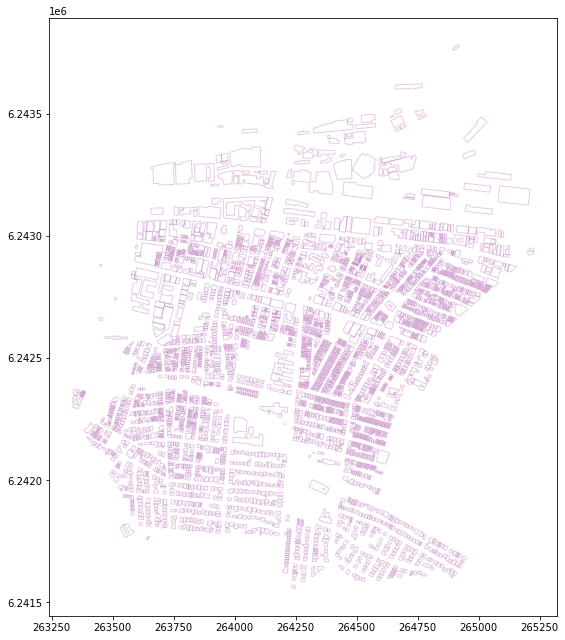

In [26]:
#%matplotlib

fig, ax = plt.subplots(figsize=(11, 11))

ts.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
if len(new_df1) > 0:
    new_df1.plot(ax=ax, edgecolor='red', facecolor='none')#, alpha=0.3)#, column='osm_building', legend=True)

#-- save
plt.savefig('./data/topologyFig', dpi=300)
#plt.show()

|  |  |
|:--------:|:--------:|
|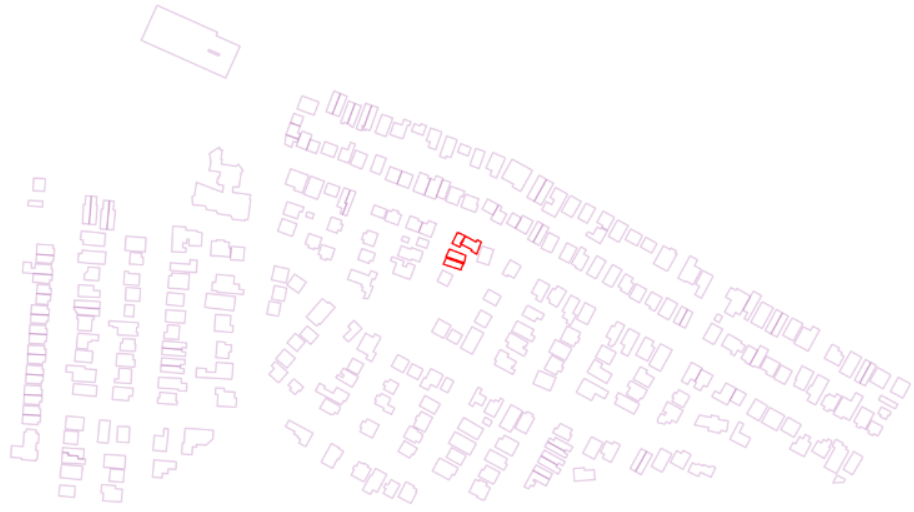 | **Typical challenges will be highlight in *Red*.**|
|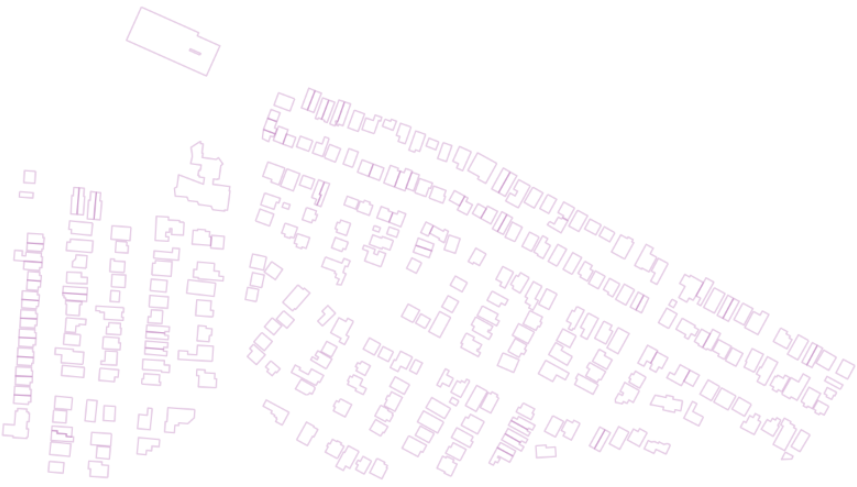| **or none**|
|<br /> **If you continue without fixing the challenges, the LoD1 City Model *will not be error free*.** | <br /> **Our goal is a topologically correct surface.** |

<h2><center>There may still be potential challenges.<br> Please ensure the quality of the value-added product and the source data.</center></h2>

**If necessary; edit [OpenStreetMap](https://www.openstreetmap.org/about) and fix the challenge please.**

<div class="alert alert-block alert-warning"><b></b>
    
And remember.  
Many [Planet.osm mirrors](https://wiki.openstreetmap.org/wiki/Planet.osm) (like the one recommended above) release a ***fresh `.osm.pbf` EVERYDAY!***  
Give the OpenStreetMap server ***at least a day*** before attempting the process again.
    
**Alchemy is a process. Please be patient.**
</div>

In [27]:
#- get the mean height of the bld
ts['mean'] = ts.apply(lambda row: rasterQuery(row.geometry, gt_forward, rb), axis = 1)
ts.head(2)
#ts.geometry = ts['geometry'].apply(lambda geom: geom.geoms[0] if geom.geom_type == "MultiPolygon" else geom)

,geometry,osm_id,osm_way_id,name,type,amenity,building,craft,historic,leisure,man_made,office,shop,sport,tourism,other_tags,tags,building:levels,building:part,mean
1,"MULTIPOLYGON (((265023.481 6242993.344, 265021...",12227309,NaN,The Neighbourgoods Market,multipolygon,marketplace,retail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Cape Town"",""addr:suburb""=>""Woods...","{'addr:city': 'Cape Town', 'addr:suburb': 'Woo...",1,None,7.17
2,"MULTIPOLYGON (((264360.391 6242908.633, 264361...",12249345,NaN,Church Square,multipolygon,NaN,apartments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Woodstock, Cape Town"",""addr:hous...","{'addr:city': 'Woodstock, Cape Town', 'addr:ho...",6,None,10.45


In [28]:
#ts['building:levels'].unique

<div class="alert alert-block alert-warning"><b>Calculate building height:</b> 

We assume a building level is 2.8 meters high and add another 1.3 meters (to account for the roof) and create a new attribute `height`.</div>

The Python code to execute the `.writejson` function is in the `city3D.py` script

In [29]:
# -- execute function. write geoJSON
#city3D.write_geojson(ts, jparams, is_geojson=False)
city3D.write_geojson(ts, jparams)#, suburb=True)

In [30]:
start = time.time()

dis = gpd.read_file(jparams['osm_bldings'])                   
dis.set_crs(epsg=int(epsg[-5:]), inplace=True, allow_override=True)

dict_vertices = {}
cols = [c for c in ['bottom_bridge_height', 'bottom_roof_height', 'roof_height'] if c in dis.columns]

dis['geometry'] = dis.geometry.apply(polygon.orient, 1)

for i, row in dis.iterrows():
    oring = list(row.geometry.exterior.coords)
    name = row['osm_id']
    for (j, v) in enumerate(oring[:-1]):
        vertex = (oring[j][0], oring[j][1])
        attr = [row[c] for c in cols]
        attr = [x for x in attr if not np.isnan(x)]  # Remove np.nan values
        if vertex in dict_vertices.keys():
            dict_vertices[vertex][row['osm_id']] = attr
        else:
            dict_vertices[vertex] = {row['osm_id']: attr}

result = {}
for k1, d in dict_vertices.items():
    for k2 in d:
        result.setdefault(k2, {})[k1] = sorted(list(set([j for i in d.values() for j in i])))
        
dis.drop(dis.index[dis['building'] == 'bridge'], inplace = True)
dis.drop(dis.index[dis['building'] == 'roof'], inplace = True)

#- create a point representing the hole within each building  
dis['x'] = dis.representative_point().x
dis['y'] = dis.representative_point().y
hs = dis[['x', 'y', 'ground_height']].copy()

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:00.927023


In [31]:
print(len(dis), 'buildings have been harvested from the osm.pbf for the', jparams["FocusArea"], 'area') 

3707 buildings have been harvested from the osm.pbf for the Woodstock area


In [32]:
#dis.sort_values(by = 'osm_building', inplace=True) 
dis.head(2)
#dis.plot()

,osm_id,address,building,building:use,building:levels,beds,building:flats,building:units,residential,rooms,social_facility,footprint,plus_code,ground_height,bottom_roof_height,building_height,roof_height,geometry,x,y
0,12227309,Woodstock Cape Town,retail,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[265023.4...",CJXQXVX7+X6V,7.17,NaN,4.1,11.27,"POLYGON ((265023.481 6242993.344, 265021.289 6...",265035.863057,6.242978e+06
1,12249345,"34 Dickson Street 7915 Woodstock, Cape Town",apartments,NaN,6,NaN,105,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[264360.3...",CMX9X9XC+X8W,10.45,NaN,18.1,28.55,"POLYGON ((264360.391 6242908.633, 264361.062 6...",264327.370820,6.242905e+06


**prepare the elevation for the TIN**

In [33]:
#- 
dis_c = dis.copy()

In [34]:
#- prepare xyz (more buildings = more time)
start = time.time()

df = pd.read_csv(jparams['xyz'],                                      
                 delimiter = ' ', header=None, names=["x", "y", "z"])
    
geometry = [Point(xy) for xy in zip(df.x, df.y)]
gdf = gpd.GeoDataFrame(df, crs=epsg, geometry=geometry)  

_symdiff = gpd.overlay(aoibuffer, dis_c, keep_geom_type=False, how='symmetric_difference')

#_mask = gdf.within(_symdiff.loc[0, 'geometry'])
#gdf = gdf.loc[_mask]

# Use STRtree for efficient spatial lookup instead of .within()
tree = STRtree(gdf.geometry)
possible_matches = tree.query(_symdiff.unary_union)  # Faster than looping over individual geometries
# Filter candidate points with actual within() check
gdf = gdf.iloc[possible_matches]
gdf = gdf[gdf.within(_symdiff.unary_union)]

gdf = gdf[gdf['z'] != jparams['nodata']]                              
gdf.reset_index(drop=True, inplace=True)
gdf = gdf.round(2)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:05:13.601749


In [36]:
dis.tail(3)

,osm_id,address,building,building:use,building:levels,beds,building:flats,building:units,residential,rooms,social_facility,footprint,plus_code,ground_height,bottom_roof_height,building_height,roof_height,geometry,x,y
3711,1314777371,NaN,garage,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[264153.9...",C6XGXHXP+X8W,20.21,NaN,4.1,24.31,"POLYGON ((264153.941 6242630.251, 264148.107 6...",264150.585825,6.242629e+06
3712,1317425439,NaN,warehouse,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[264028.5...",CVXHX6X3+XPW,5.52,NaN,4.1,9.62,"POLYGON ((264028.583 6243133.267, 264025.150 6...",264051.204336,6.243116e+06
3713,1340498943,Balfour Street Woodstock Cape Town,semidetached_house,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[264277.1...",CGXWX6X9+X5W,55.90,NaN,4.1,60.00,"POLYGON ((264277.101 6242210.386, 264272.196 6...",264278.217939,6.242203e+06


<div class="alert alert-block alert-warning"><b>Prepare for Triangle:</b> </div>

The Python code to execute the `city3D.functions` are in the `city3D.py` script

In [37]:
#- harvest the building vertices. typically the corners. 
ac, c, min_zbld = city3D.getBldVertices(dis, gt_forward, rb)
idx = []
#- segments 
idx, idx01 = city3D.createSgmts(ac, c, gdf, idx)
#- populate the .df with coordinate values (the vertices)
df2 = city3D.concatCoords(gdf, ac)

#- do the same for the area of interest
acoi, ca = city3D.getAOIVertices(aoibuffer, gt_forward, rb)
idx, idx01 = city3D.createSgmts(acoi, ca, df2, idx)
df3 = city3D.concatCoords(df2, acoi)

**Triangle**

In [40]:
pv_pts = df3[['x', 'y', 'z']].values

In [41]:
#pts = df3[['x', 'y']].values 
#A = dict(vertices=pts)
#Tr = tr.triangulate(A)
#len(ac)

In [42]:
holes01 = hs[['x', 'y']].round(3).values.tolist()
pts = df3[['x', 'y']].values #, 'z']].values

#the terrain without the blds
A = dict(vertices=pts, segments=idx, holes=holes01)

Tr = tr.triangulate(A, 'p')                  
terrTin = Tr.get('triangles').tolist()

In [43]:
#terrTin

**CityJSON**

In [44]:
#- 
minz = df3['z'].min()
maxz = df3['z'].max()

In [45]:
#min_zbld

<div class="alert alert-block alert-warning"><b>create CityJSON</b> </div>

The Python code to execute the `.output_cityjson` function is in the `city3D.py` script

In [46]:
# -- execute function. create CityJSON
city3D.output_cityjson(extent, minz, maxz, terrTin, pv_pts, jparams, min_zbld, acoi, result) 

In [47]:
src_ds = None

<div class="alert alert-block alert-info"><b></b> 

**Go over to [Ninja the online CityJSON viewer](https://ninja.cityjson.org/#) and explore!**

</div>

**You are welcome to further investigate the quality of a 3D Model.**

**The [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) web app will test CityJSON geometric primitives.**

**If you parse the result of this notebook through [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) it will return a report with an invalid [TINRelief](https://www.cityjson.org/specs/1.1.1/#tinrelief) and error.**
<br>
<br>
<img src="data/iso19107_error.jpg" width="550"/>
<br>
<br>
**This particular area contains Buildings with courtyards. The courtyards** (polygons) **are islands of terrain disconnected from the *larger* TINRelief** (shell); **thus the error<sup>*</sup>.**
<br>
<br>
<sup>* <sub>***Don't take my word for it. Test and see for yourself!*** `osm3Dsaao_param.json` (South African Royal Observatory, Cape Town) will produce a 100% topologically correct [Open Geospatial Consortium (OGC)](https://www.ogc.org/standard/citygml/) standard LoD1 3D model that conforms to the [ISO 19107 spatial schema for 3D primatives](https://www.iso.org/standard/66175.html) *[connecting and planar surfaces, correct orientation of the surfaces and watertight volumes]*</sub> 

<div class="alert alert-block alert-warning"><b>NOW</b><br><br>


***To understand the value and usefulness of a 3D City Model***; parse the result of this Notebook through [CityJSONspatialDataScience.ipynb](https://github.com/AdrianKriger/geo3D/blob/main/CityJSONspatialDataScience.ipynb) to workthrough an example of:  
- population estimation and
- a calculation of [Building Volume per Capita]((https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs)
</div>

***As always; you are welcome to raise an issue. I depend on you to help me improve.***

<a id='Section2'></a>

<div class="alert alert-block alert-success"><b>2. Possible Secondary and Tertiary level conversations starters:</b></div>

| **Topic**                                | **Secondary Level Questions**                                                                                                                                                                                   | **Tertiary Level Questions**                                                                                                                                                                                                                   |
|------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Geography** | - Talk about the main difference between a globe and a map, and why we use map projections to represent the Earth on a flat surface<br>- Explain why different map projections are used for different purposes. For example, why might a Mercator projection be useful for navigation, but not for comparing the sizes of countries? | - Discuss why it is necessary to convert geographic coordinates (latitude and longitude) to a projected coordinate system in the context of the geospatial sciences. What are some potential issues if this conversion is not done? <br>- How does geodesy contribute to the geospatial sciences?|